
#CNN 이미지 분류 (TensorFlow) 2.0



###시작하기 전, CNN에 대해 간략히 설명할 것이다.

#**1. Tensorflow 설치**

### 1) CNN을 설명하기 위해 텐서플로우 2.0을 설치한다.




In [2]:
pip install --upgrade tensorflow

### 2) 패키지 import

In [3]:
import tensorflow as tf              #tensorflow를 tf로
import tensorflow_datasets as tfds   #tensorflow에서 제공하는 data를 이용하기 위해 tfds를 import해준다.

import numpy as np                   #기본적인 수학적 연산(array 연산 등)을 위해 numpy를 import한다.
import matplotlib.pyplot as plt      #CNN 학습 진행상황을 확인하기 위한 matplotlib.pyplot을 import 해준다.

#**2. What is CNN**



---
CNN(Convolutional Neural Network)는 이미지의 특징을 추출하기 위해 Convolution 연산을 활용해 Fully-Connected된 dense layer 대신 Convolutional layer를 사용해 학습시키는 딥러닝 방식이다.


왜 기존의 DNN 대신 CNN을 사용할까?
컴퓨터 비전 분야에서 합성곱 신경망을 사용하는 것이 효과적이기 때문이다. 왜 효과적인지 예시를 들어 설명할 것이다.

64x64x3 고양이 사진을 fully connected된 layer에서 처리하기 위해서는 입력값의 크기는 12288이 된다. 그러나 사진의 크기가 1000x1000x3 정도로 커진다면 모델 크기, 가중치 행렬 등의 크기가 너무 커져 정상적인 모델을 만들기 어려워진다. 그렇다면 fully connected layer없이 어떻게 가중치를 학습시킬까?

그것이 바로 convolution 연산을 사용하는 것인데,
convolution연산(이하 합성곱)을 사용하면 사진의 특징을 추출할 수 있게 된다. 이러한 합성곱연산을 수행하는 행렬을 필터라고 하는데, 이 필터에 이미지 특성이 있으면 이미지와 필터의 합성곱 결과에 해당 이미지 특성을 추출할 수 있다.


합성곱 연산을 설명하기 위해 다음과 같은 image example이 있다고 하자.

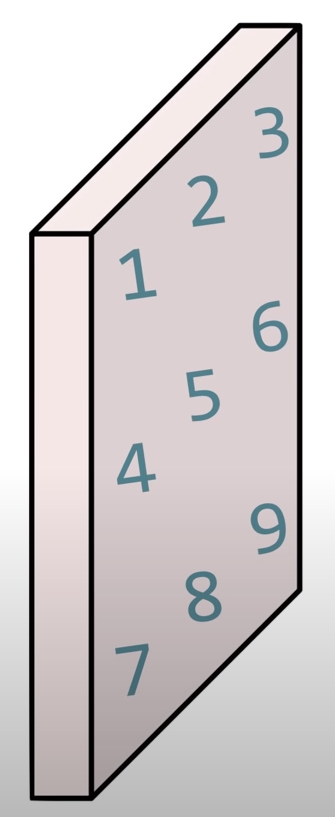

해당 이미지를 image라는 변수에 array로 나타내고 이때 import했던 numpy를 사용한다.


이미지의 크기는 (1,3,3,1)이다.

(1, 3, 3, 1)


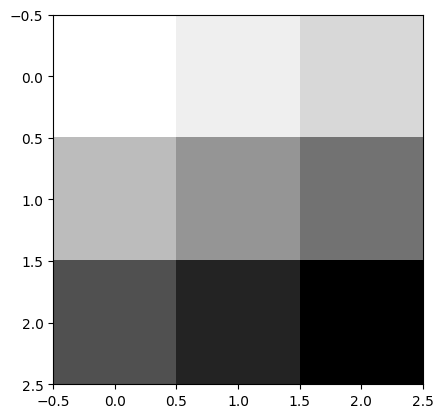

In [4]:
sess = tf.compat.v1.InteractiveSession()
image = np.array([[[[1],[2],[3]],
                   [[4],[5],[6]],
                   [[7],[8],[9]]]], dtype=np.float32)
print(image.shape)
plt.imshow(image.reshape(3,3), cmap='Greys')

# convolution without padding

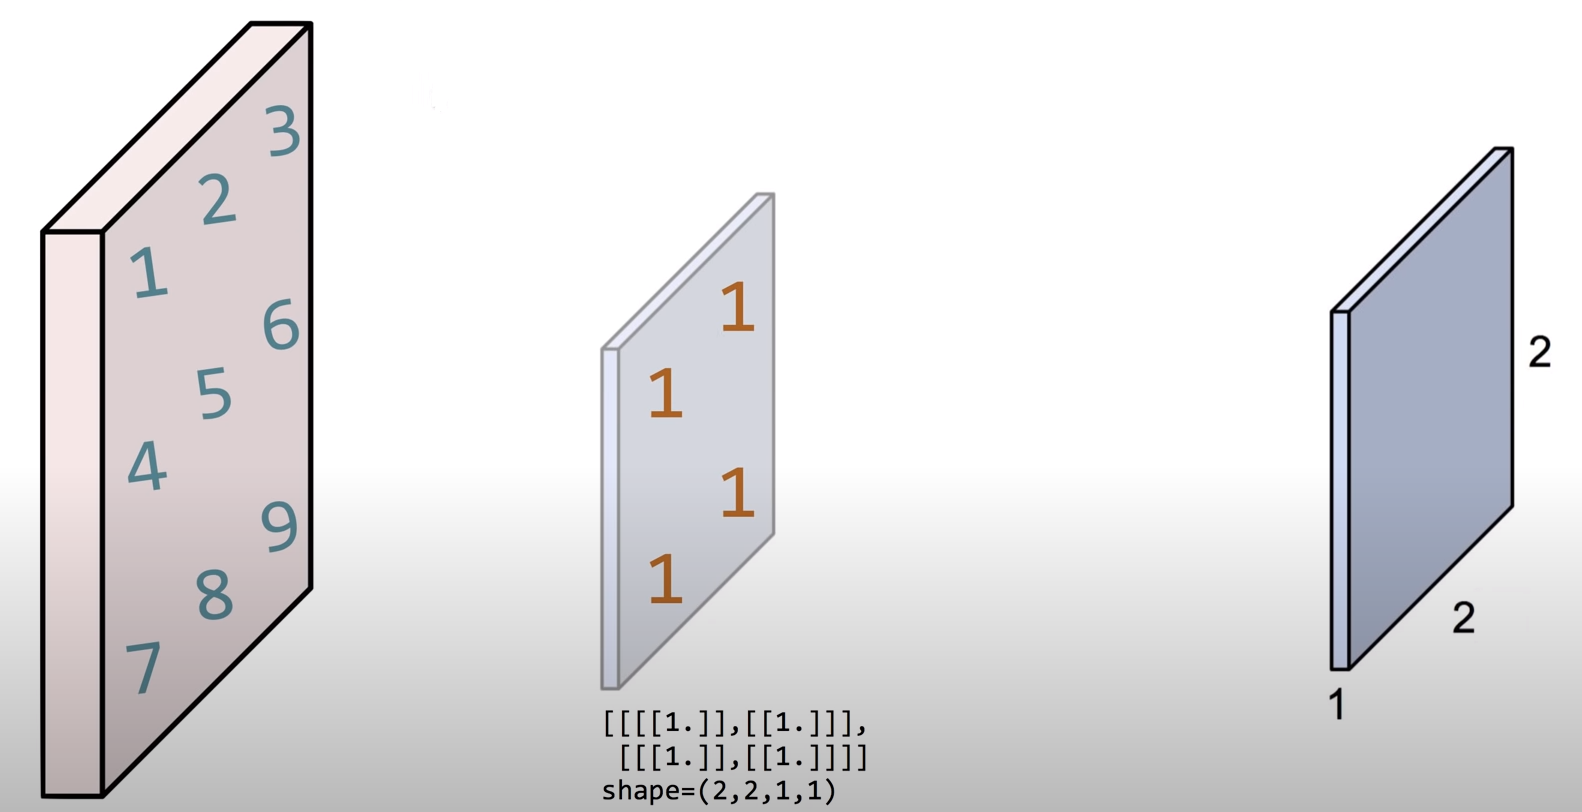

우선 padding은 차치하고 image example에 (2,2,1,1) 크기의 필터를 합성곱 시킨다는 것은,

필터를 좌측상단의 위치에서 한칸씩 우측으로 하단으로 이동시켜가며 element-wise 곱의 sum을 결과값으로 저장하는 것이다.

예를 들어 합성곱을 시작하면 1x1 + 2x1 + 4x1 + 5x1 = 12 가 합성곱 결과의 첫 번째 값이 되는 것이다.
그렇다면 필터는 오른쪽으로 한 번이동 하단으로 한 번 이동 가능하므로 총 네번의 연산을 통해 합성곱 결과는 (1,2,2,1) 이 됨을 알 수 있다.

이 때, 합성곱 필터가 몇 칸씩 움직일 것이냐를 의미하는 단위가 stide, 합성곱 결과의 변화를 주기위해 이미지의 가장자리에 추가 픽셀을 얼마나 넣을지를 나타내는 단위를 padding이라고 한다. 위의 결과처럼 합성곱을 하면 이미지 사이즈가 작아져 반복적인 합성곱 연산으로 인해 이미지 사이즈가 작아지는 것을 막기위해 패딩을 사용하기도 한다.

image.shape (1, 3, 3, 1)
weight.shape (2, 2, 1, 1)
conv2d.shape (1, 2, 2, 1)
[[12. 16.]
 [24. 28.]]


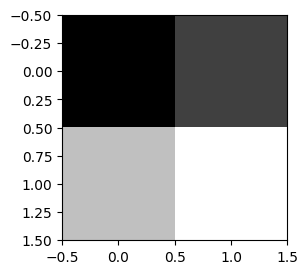

In [5]:
print("image.shape", image.shape)        # 위에서 정의한 image example의 크기이다.
weight = tf.constant([[[[1.]],[[1.]]],
                      [[[1.]],[[1.]]]])  # weight는 합성곱 필터이다.
print("weight.shape", weight.shape)      # 합성곱 필터의 크기를 출력한다. (2,2,1,1)
conv2d = tf.nn.conv2d(image, weight, strides=[1, 1, 1, 1], padding='VALID')  #padding은 사용하지 않고 stride=1 로 하여 합성곱을 진행하였다.


print("conv2d.shape", conv2d.shape)      # 합성곱의 결과의 크기를 출력한다. (1,2,2,1)
conv2d = np.swapaxes(conv2d, 0, 3)       # 합성곱 결과 시각화를 위해 (1, height, width, 1)에서 (1, 1, height, width)로 바꾸어

for i, one_img in enumerate(conv2d):     # 합겅곱 결과를 (2,2)로 출력하고 이미지로 나타낸다. 위에서 계산한 결과와 같다.
    print(one_img.reshape(2,2))
    plt.subplot(1,2,i+1), plt.imshow(one_img.reshape(2,2), cmap='gray')

# Convolution with SAME padding

위에서는 패딩을 'VALID'로 설정하여 패딩을 사용하지 않았고 결과 이미지 사이즈가 줄었다. same padding을 이용하면 input 이미지와 output 이미지의 크기가 같아지도록 픽셀을 가장자리에 자동으로 추가하여 연산해준다. 코드로 확인해보겠다.

>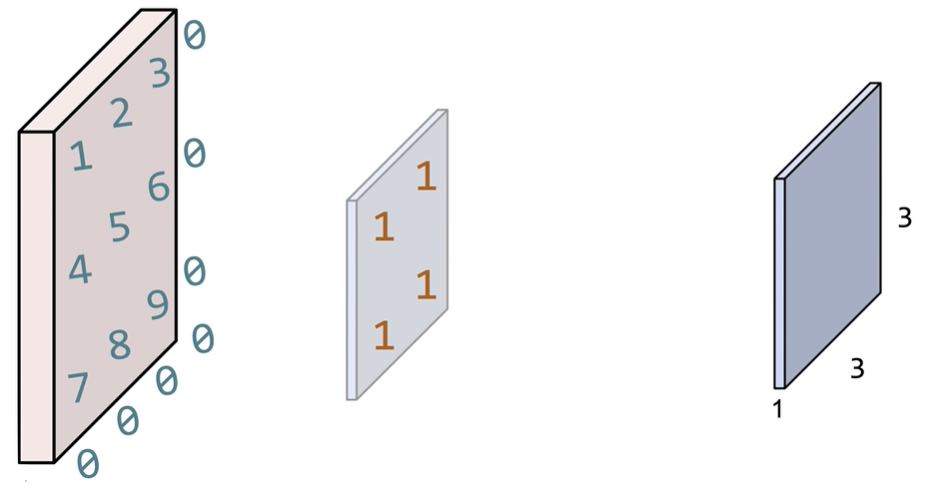



image.shape (1, 3, 3, 1)
weight.shape (2, 2, 1, 1)
conv2d.shape (1, 3, 3, 1)
[[12. 16.  9.]
 [24. 28. 15.]
 [15. 17.  9.]]


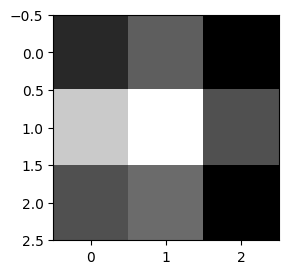

In [6]:
print("image.shape", image.shape)

weight = tf.constant([[[[1.]],[[1.]]],
                      [[[1.]],[[1.]]]])
print("weight.shape", weight.shape)

# 위에서 동일한 이미지와 필터를 사용해주었는데, 합성곱 연산에서 padding을 'SAME'으로 설정했다.
conv2d = tf.nn.conv2d(image, weight, strides=[1, 1, 1, 1], padding='SAME')
print("conv2d.shape", conv2d.shape)
conv2d_img = np.swapaxes(conv2d, 0, 3)
for i, one_img in enumerate(conv2d_img):
    print(one_img.reshape(3,3))
    plt.subplot(1,2,i+1), plt.imshow(one_img.reshape(3,3), cmap='gray')

# 결과 이미지의 크기가 (1,3,3,1)로 input과 output 이미지의 사이즈가 동일하다.

# 3 filters


이번에는 한 개의 필터만 사용하지 않고 세 개의 필터를 사용해 합성곱 연산을 진행할 것이다. (2,2,1,3)

필터의 사이즈는 (2,2,1)이 세장 있는 형태로 각 필터와 이미지가 합성곱 되어 conv2d에 저장되고 (3,3) output이 세 장 나오는 것을 확인할 수 있다.

image.shape (1, 3, 3, 1)
weight.shape (2, 2, 1, 3)
conv2d.shape (1, 3, 3, 3)
[[12. 16.  9.]
 [24. 28. 15.]
 [15. 17.  9.]]
[[120. 160.  90.]
 [240. 280. 150.]
 [150. 170.  90.]]
[[-12. -16.  -9.]
 [-24. -28. -15.]
 [-15. -17.  -9.]]


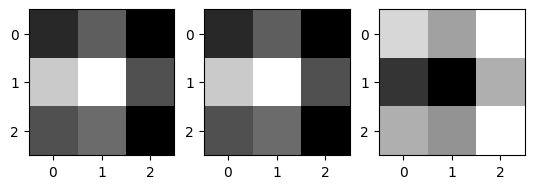

In [7]:
print("image.shape", image.shape)

weight = tf.constant([[[[1.,10.,-1.]],[[1.,10.,-1.]]],
                      [[[1.,10.,-1.]],[[1.,10.,-1.]]]])
print("weight.shape", weight.shape)
conv2d = tf.nn.conv2d(image, weight, strides=[1, 1, 1, 1], padding='SAME')
print("conv2d.shape", conv2d.shape)
conv2d = np.swapaxes(conv2d, 0, 3)
for i, one_img in enumerate(conv2d):
    print(one_img.reshape(3,3))
    plt.subplot(1,3,i+1), plt.imshow(one_img.reshape(3,3), cmap='gray')

[링크 텍스트](https:// [링크 텍스트](https://))# Max Pooling

Pooling이란 이미지에서 대표값을 추출해 이미지 사이즈를 줄이는 방법이다. 이 때 대표값을 최댓값으로 하는 Pooling 방식을 max pooling이라고 한다.

max pooling을 하는 단계를 max pooling layer 라고 한다.
예를 통해 살펴보면 더 쉽게 이해할 수 있다.
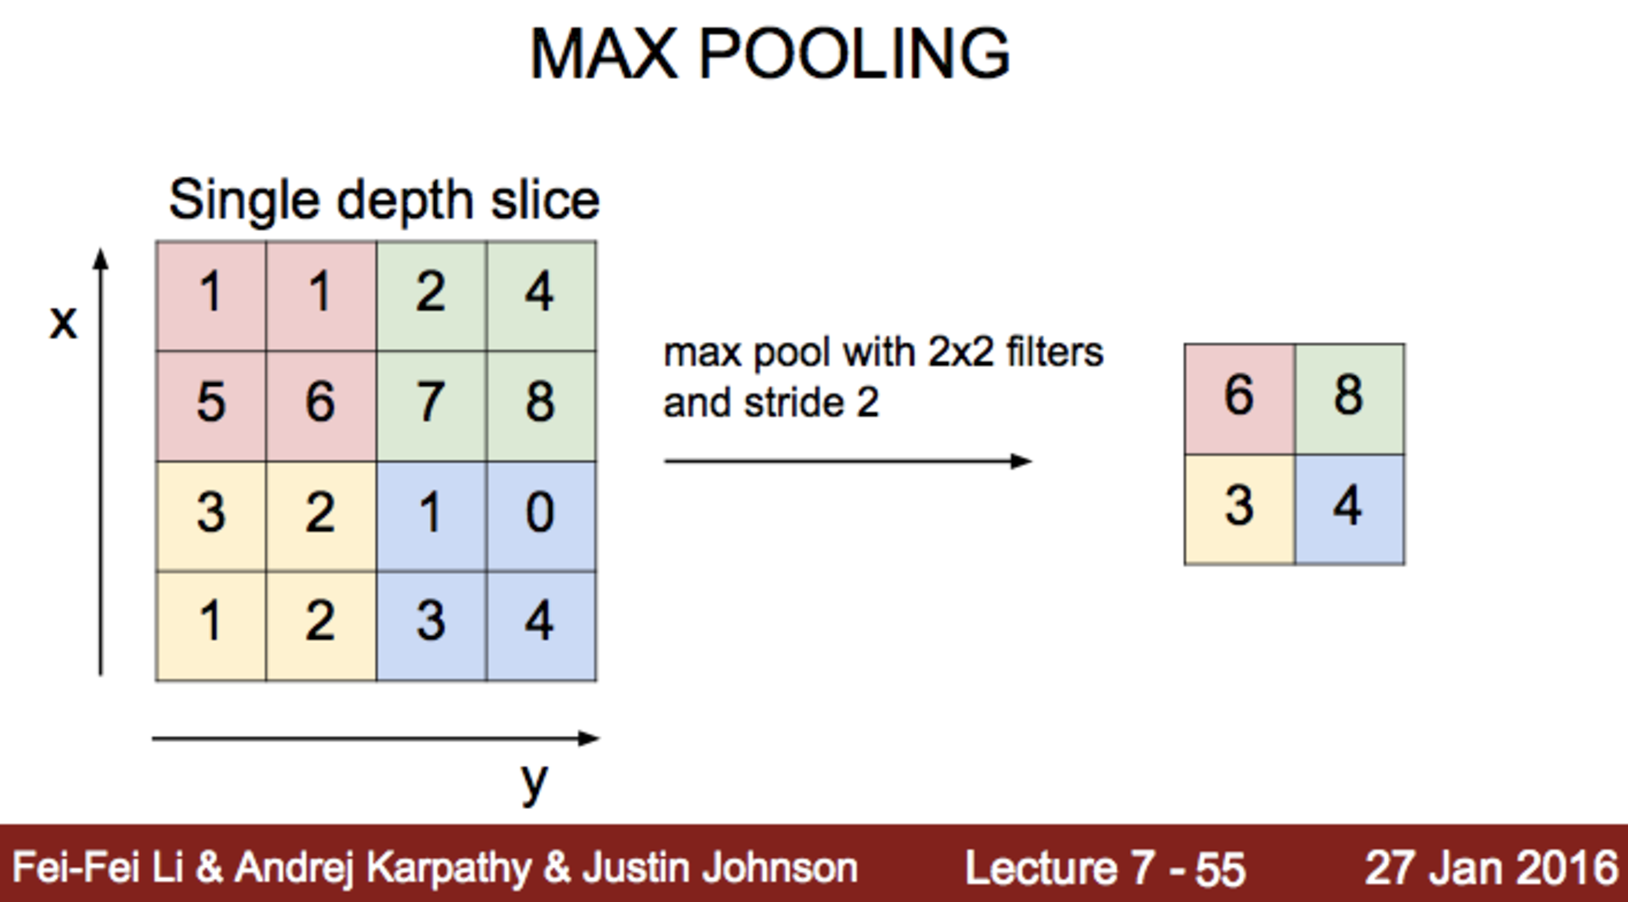

필터 사이즈가 (2,2,1) 이고 stride=2 이므로 두 칸씩 이동하며 최댓값을 찾게된다.
필터의 첫 번째 연산을 살펴보면 1,1,5,6 에서 최댓값인 6을 2,4,7,8 에서 최댓값인 8을 구한 것을 알 수 있다.

In [8]:
image = np.array([[        [[1],[1],[2],[4]],
                   [[5],[6],[7],[8]],
                   [[3],[2],[1],[0]],
                   [[1],[2],[3],[4]]          ]], dtype=np.float32)   # 위의 이미지를 np.array를 통해 나타내었다.
print(image.shape)  # (1,4,4,1)

pool = tf.nn.max_pool(image, ksize=2, strides=2, padding='VALID')     # stride를 2로 필터사이즈는 (2,2,1)로 pooling하면

print(pool.shape)                                                     # 6,8,3,4를 추출할 수 있다.
pool

(1, 4, 4, 1)
(1, 2, 2, 1)


<tf.Tensor: shape=(1, 2, 2, 1), dtype=float32, numpy=
array([[[[6.],
         [8.]],

        [[3.],
         [4.]]]], dtype=float32)>

#**3. CNN에서 사용되는 연산들을 살펴보았고 이제는 해당 연산들을 바탕으로 실제 이미지를 모델에 넣어 학습해볼 것이다.**




##1)하이퍼파라미터 값을 설정한다.

In [20]:
padding = "SAME"  #@param ['SAME', 'VALID' ]
#패딩을 SAME으로 설정한다.
batch_size = 32  #@param {type: "number"}
#batch사이즈를 32로 주어 한 번 학습할 때 32개의 데이터 샘플을 사용한다.
learning_rate = 0.001  #@param {type: "number"}
#Learning Rate는 0.001로 설정하였다.



## 2) Fetching the Dataset

We fetch our dataset from TensorFlow Datasets which makes much of the data preprocessing easier ;-)


In [9]:
dataset_name = 'horses_or_humans'  #@param {type: "string"}

dataset, info = tfds.load( name = dataset_name, split = tfds.Split.TRAIN, with_info=True) # train data만 추출한다.
dataset = dataset.shuffle( 1024 ).batch( batch_size ) # 효과적인 학습을 위해 data를 shuffle한다.

info #데이터가 300x300x3 크기임을 확인할 수 있다.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteL4L86S/horses_or_humans-train.tfrecord*..…

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/horses_or_humans/3.0.0.incompleteL4L86S/horses_or_humans-test.tfrecord*...…

Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir=PosixGPath('/tmp/tmp6v0jqa9stfds'),
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [10]:
info.splits

train_size = info.splits['train'].num_examples
test_size = info.splits['test'].num_examples
print('train_size: {} 개\ntest_size: {} 개'.format(train_size, test_size))

train_size: 1027 개
test_size: 256 개


In [11]:
class_names = info.features['label'].names
class_names

['horses', 'humans']

Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 0
Label: 1


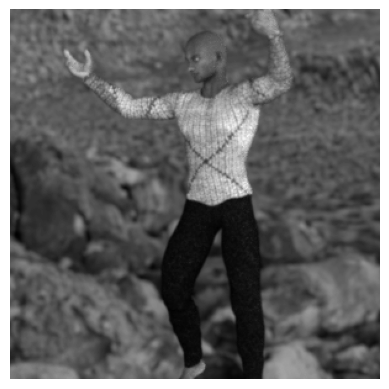

In [12]:
train_dataset = tfds.load(name=dataset_name, split=tfds.Split.TRAIN)
for data in train_dataset.take(8):
    image_train, label_train = data['image'], data['label']
    plt.imshow(image_train.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    plt.axis('off')
    print("Label: %d" % label_train.numpy())

Label: 0
Label: 0
Label: 0
Label: 1
Label: 1
Label: 0
Label: 0
Label: 1


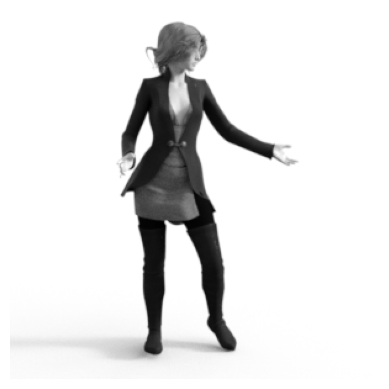

In [13]:
test_dataset = tfds.load(name=dataset_name, split=tfds.Split.TEST)
for data in test_dataset.take(8):
    image_test, label_test = data['image'], data['label']
    plt.imshow(image_test.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    plt.axis('off')
    print("Label: %d" % label_test.numpy())


## 3) Defining CNN operations

For our CNN model, we mainly use three operations ( layers ).

1. `conv2d` : Performs convolutions over the `inputs` matrix with kernels ( `filters` ) and `stride_size`. Also, it performs the Leaky ReLU activation function.

2. `maxpool` : Performs max pooling over the `inputs`.

3. `dense` : Dense layers for the CNN with dropout.


In [14]:
leaky_relu_alpha = 0.2 #@param {type: "number"}
dropout_rate = 0.5 #@param {type: "number"}

def conv2d( inputs , filters , stride_size ):
    out = tf.nn.conv2d( inputs , filters , strides=[ 1 , stride_size , stride_size , 1 ] , padding=padding )
    return tf.nn.leaky_relu( out , alpha=leaky_relu_alpha )

def maxpool( inputs , pool_size , stride_size ):
    return tf.nn.max_pool2d( inputs , ksize=[ 1 , pool_size , pool_size , 1 ] , padding='VALID' , strides=[ 1 , stride_size , stride_size , 1 ] )

def dense( inputs , weights ):
    x = tf.nn.leaky_relu( tf.matmul( inputs , weights ) , alpha=leaky_relu_alpha )
    return tf.nn.dropout( x , rate=dropout_rate )



## 4) Initializing CNN weights

We initialize the weights for our CNN. The shapes need to calculated but the `tf.nn.conv2d` expects the filters to have a shape of `[ kernel_size , kernel_size , in_dims , out_dims ]`.

We use the `glorot_uniform` initializer for our weights.


In [15]:

output_classes = 2
initializer = tf.initializers.glorot_uniform()
def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True , dtype=tf.float32 )

shapes = [
    [ 3 , 3 , 3 , 16 ] ,
    [ 3 , 3 , 16 , 16 ] ,
    [ 3 , 3 , 16 , 32 ] ,
    [ 3 , 3 , 32 , 32 ] ,
    [ 3 , 3 , 32 , 64 ] ,
    [ 3 , 3 , 64 , 64 ] ,
    [ 3 , 3 , 64 , 128 ] ,
    [ 3 , 3 , 128 , 128 ] ,
    [ 3 , 3 , 128 , 256 ] ,
    [ 3 , 3 , 256 , 256 ] ,
    [ 3 , 3 , 256 , 512 ] ,
    [ 3 , 3 , 512 , 512 ] ,
    [ 8192 , 3600 ] ,
    [ 3600 , 2400 ] ,
    [ 2400 , 1600 ] ,
    [ 1600 , 800 ] ,
    [ 800 , 64 ] ,
    [ 64 , output_classes ] ,
]

weights = []
for i in range( len( shapes ) ):
    weights.append( get_weight( shapes[ i ] , 'weight{}'.format( i ) ) )


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [16]:
weights

[<tf.Variable 'weight0:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
 array([[[[-0.07832649, -0.13262466, -0.08742375,  0.03290349,
           -0.02999769,  0.12599769,  0.16179326,  0.07624623,
            0.1104655 , -0.07756066, -0.09427873, -0.0174844 ,
            0.0879598 ,  0.01526511,  0.01833346, -0.13679397],
          [ 0.06272781, -0.1299    , -0.11127883, -0.15275304,
           -0.11024875, -0.1255603 ,  0.17100984,  0.13743761,
           -0.01941209, -0.08813009,  0.00991338,  0.09426028,
           -0.04124962, -0.12279461,  0.17694545,  0.08045024],
          [-0.07129666, -0.17954867, -0.14717172,  0.18264249,
            0.10234267,  0.07568142, -0.07620009, -0.11270464,
            0.07410794,  0.00970294, -0.10597931, -0.17232752,
           -0.16959934, -0.12773153,  0.08307007, -0.0952917 ]],
 
         [[ 0.04875775,  0.18475673,  0.10046193, -0.03044438,
           -0.16418673,  0.03278144, -0.13254404, -0.07300995,
           -0.02874865, -0.00032039,  0.0923

## 5) Assembling the operations

We put together all the CNN ops we defined earlier into a final model which we will use for training finally.


In [17]:
def model( x ) :
    x = tf.cast( x , dtype=tf.float32 )
    c1 = conv2d( x , weights[ 0 ] , stride_size=1 )
    c1 = conv2d( c1 , weights[ 1 ] , stride_size=1 )
    p1 = maxpool( c1 , pool_size=2 , stride_size=2 )

    c2 = conv2d( p1 , weights[ 2 ] , stride_size=1 )
    c2 = conv2d( c2 , weights[ 3 ] , stride_size=1 )
    p2 = maxpool( c2 , pool_size=2 , stride_size=2 )

    c3 = conv2d( p2 , weights[ 4 ] , stride_size=1 )
    c3 = conv2d( c3 , weights[ 5 ] , stride_size=1 )
    p3 = maxpool( c3 , pool_size=2 , stride_size=2 )

    c4 = conv2d( p3 , weights[ 6 ] , stride_size=1 )
    c4 = conv2d( c4 , weights[ 7 ] , stride_size=1 )
    p4 = maxpool( c4 , pool_size=2 , stride_size=2 )

    c5 = conv2d( p4 , weights[ 8 ] , stride_size=1 )
    c5 = conv2d( c5 , weights[ 9 ] , stride_size=1 )
    p5 = maxpool( c5 , pool_size=2 , stride_size=2 )

    c6 = conv2d( p5 , weights[ 10 ] , stride_size=1 )
    c6 = conv2d( c6 , weights[ 11 ] , stride_size=1 )
    p6 = maxpool( c6 , pool_size=2 , stride_size=2 )

    flatten = tf.reshape( p6 , shape=( tf.shape( p6 )[0] , -1 ))

    d1 = dense( flatten , weights[ 12 ] )
    d2 = dense( d1 , weights[ 13 ] )
    d3 = dense( d2 , weights[ 14 ] )
    d4 = dense( d3 , weights[ 15 ] )
    d5 = dense( d4 , weights[ 16 ] )
    logits = tf.matmul( d5 , weights[ 17 ] )

    return tf.nn.softmax( logits )



## 6) Defining the loss function and optimization using `tf.GradientTape`

We use `tf.losses.categorical_crossentropy` as our loss function. Now comes `tf.GradientTape`, an automatic differentiation engine which records all the derivatives within its scope.

The `train_step` function takes in a batch of data, calculates the loss and gradients and then with `optimizer.apply_gradients`, we update the `weights`.


In [18]:

def loss( pred , target ):
    return tf.losses.categorical_crossentropy( target , pred )    # 크로스엔트로피 로스를 사용하였다.

optimizer = tf.optimizers.Adam( learning_rate )                   # 옵티마이저를 adam으로 사용한다.


## 7) Final Training

We train our model for a specific number of epochs.


epoch1:
tf.Tensor(10.577499, shape=(), dtype=float32)
tf.Tensor(6.5479765, shape=(), dtype=float32)
tf.Tensor(7.5553575, shape=(), dtype=float32)
tf.Tensor(9.57012, shape=(), dtype=float32)
tf.Tensor(8.562738, shape=(), dtype=float32)
tf.Tensor(8.562738, shape=(), dtype=float32)
tf.Tensor(9.570119, shape=(), dtype=float32)
tf.Tensor(8.562738, shape=(), dtype=float32)
tf.Tensor(6.044286, shape=(), dtype=float32)
tf.Tensor(6.5479765, shape=(), dtype=float32)
tf.Tensor(7.5553575, shape=(), dtype=float32)
tf.Tensor(9.066429, shape=(), dtype=float32)
tf.Tensor(7.555357, shape=(), dtype=float32)
tf.Tensor(6.5479765, shape=(), dtype=float32)
tf.Tensor(10.07381, shape=(), dtype=float32)
tf.Tensor(7.555357, shape=(), dtype=float32)
tf.Tensor(5.540595, shape=(), dtype=float32)
tf.Tensor(7.555357, shape=(), dtype=float32)
tf.Tensor(9.57012, shape=(), dtype=float32)
tf.Tensor(10.07381, shape=(), dtype=float32)
tf.Tensor(7.555357, shape=(), dtype=float32)
tf.Tensor(10.07381, shape=(), dtype=float32

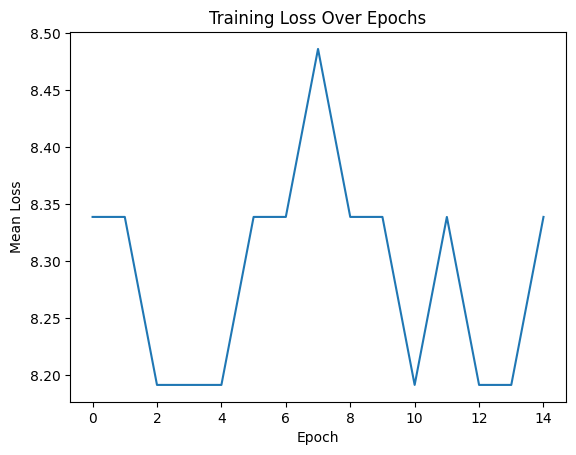

In [22]:
num_epochs = 1000 #@param {type: "number"}

losses = []  # 에폭별 평균 손실을 저장하기 위한 리스트
for epoch in range( num_epochs ):
    epoch_loss = 0.0
    print("epoch"+ str(epoch+1) + ":")

    for features in dataset:
        image , label = features[ 'image' ] , features[ 'label' ]

        with tf.GradientTape() as tape:
          current_loss = loss( model( image ), tf.one_hot( label , depth=2 ))
        grads = tape.gradient( current_loss , weights )
        optimizer.apply_gradients( zip( grads , weights ) )
        print( tf.reduce_mean( current_loss ) )

        epoch_loss += tf.reduce_mean(current_loss)

    epoch_loss /= len(dataset)  # len of dataset: 32
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss}")


plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.show()


In [ ]:
weights